In [16]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.cm as cm

from scipy.spatial import distance_matrix
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.manifold import TSNE
import torch

from data import DataGatherer
import params
from test import encode_data
from models import load_model

In [17]:
param_dic = params.__get_dict__()
print(param_dic["data_spliting"])

{'augmentations': ['addSomeNoise'],
 'batch_size': 256,
 'class_hidden_size': 256,
 'class_layers_nb': 1,
 'conv_features1_nb': 80,
 'conv_features2_nb': 30,
 'conv_kernel1_size': 15,
 'conv_kernel2_size': 5,
 'conv_layers_nb': 4,
 'data_limit': -1,
 'data_spliting': 'pos_split',
 'data_test_rate': 0.01,
 'data_type': 'not_complex',
 'data_use_position': False,
 'datafile': '/srv/public/Thibaud/datasets/ultrasec/Messung_9/messung9.2_data.npy',
 'device': 'cuda',
 'dropout_value': 0,
 'expender_hidden_size': 256,
 'expender_layers_nb': 1,
 'expender_out': 32,
 'feature_norm': 'layer',
 'flat_data': False,
 'labelfile': '/srv/public/Thibaud/datasets/ultrasec/Messung_9/messung9.2_labels.npy',
 'lambda_cov': 4,
 'lambda_distance': 11,
 'lambda_std': 1.2,
 'lambda_triplet': 10,
 'latent_dimention': 32,
 'learning_rate': 0.001,
 'loss': 'vicreg',
 'lr_limit': 0.0001,
 'model_name': 'Transformer3',
 'nb_epochs': 10000,
 'noise_amount': 0,
 'num_dev': 9,
 'num_pos': 48,
 'optimizer': 'Adam',
 

In [18]:
data = np.load(params.datafile)
label = np.load(params.labelfile)

num_classes = max(label[:, 0])
num_positions = max(label[:, 1])
print(num_classes, num_positions)

8 49


In [19]:
dg = DataGatherer()
trainDataloader, valDataloader = dg.spliting_data()

In [54]:
model = torch.load("../data/model2_1500.pth")

In [55]:
encoded_train, labels_train = encode_data(model, trainDataloader)
encoded_test, labels_test = encode_data(model, valDataloader)

# To do to try

- XGBoost classify the encoded values
- Code a little Re-Identification setup on the test+train data
    - Basic anchor + distance to anchor seting (no need to update)
- Vote on n sample of same device elements (does it improve from accuracy ?)
- Estimate the time to encode + computational needs
- Try isolated device from train to reid between all positions
- Try multiple unseen positions if they match one to another
- Do a study of capabilities according to the amount of data available and it's cleaness

In [ ]:
# Plotting
def scatter_plot(X, Y):
        dimentions = [[2*i, i*2+1] for i in range(1)]
        colors_base = cm.rainbow(np.linspace(0, 1, num_classes+1))
        plt.rcParams["figure.figsize"] = (5,5)
        cmap, norm = matplotlib.colors.from_levels_and_colors(np.arange(0, num_classes+2)- 0.5, colors_base)

        for i in range(len(dimentions)):
                fig, ax = plt.subplots()
                scatter = ax.scatter(X[:, dimentions[i][0]], X[:, dimentions[i][1]], c=Y, norm=norm, cmap=cmap, marker=".", linewidths=0.5, s=25)
                handles, lab = scatter.legend_elements(prop="colors", num=num_classes+1, alpha=0.6)
                legend1 = ax.legend(handles, lab,
                        loc="lower left", title="Device id")
                ax.add_artist(legend1)
                ax.set_title("dimentions " + str(i*2) + "and " + str(i*2+1))
                # .legend(loc='upper left',prop = {'size':7},bbox_to_anchor=(1,1))
                # plt.tight_layout(pad=5)
                plot_img = "data/plot_"+str(i)+".png"
        return fig

8


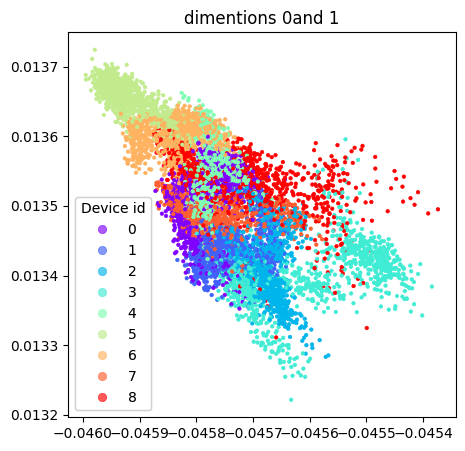

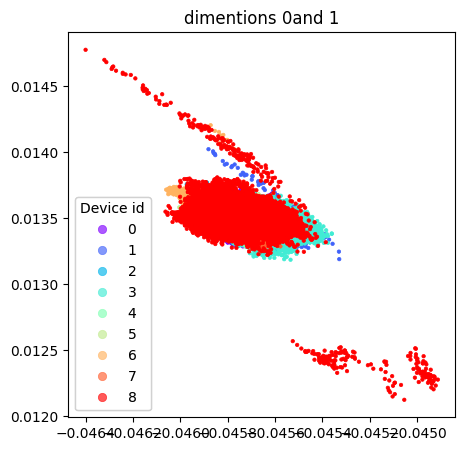

In [ ]:
print(max(labels_test))
scatter_plot(np.array(encoded_test), np.array(labels_test))
plt.show()

scatter_plot(np.array(encoded_train), np.array(labels_train))
plt.show()

In [ ]:
# For each class, gather the centroid from train data as an anchor
centroids = []

for dev in range(num_classes+1):
    ids_dev = np.where(np.array(labels_train) == dev)
    class_encoded = np.array(encoded_train)[ids_dev]
    centroids.append(class_encoded.mean(axis=0))

centroids = np.array(centroids)
print(centroids.shape)


(9, 450)


(9465, 9)
[0.0017249  0.00190838 0.00186791 0.00195905 0.00169288 0.00187085
 0.00199819 0.00175776 0.00180507]


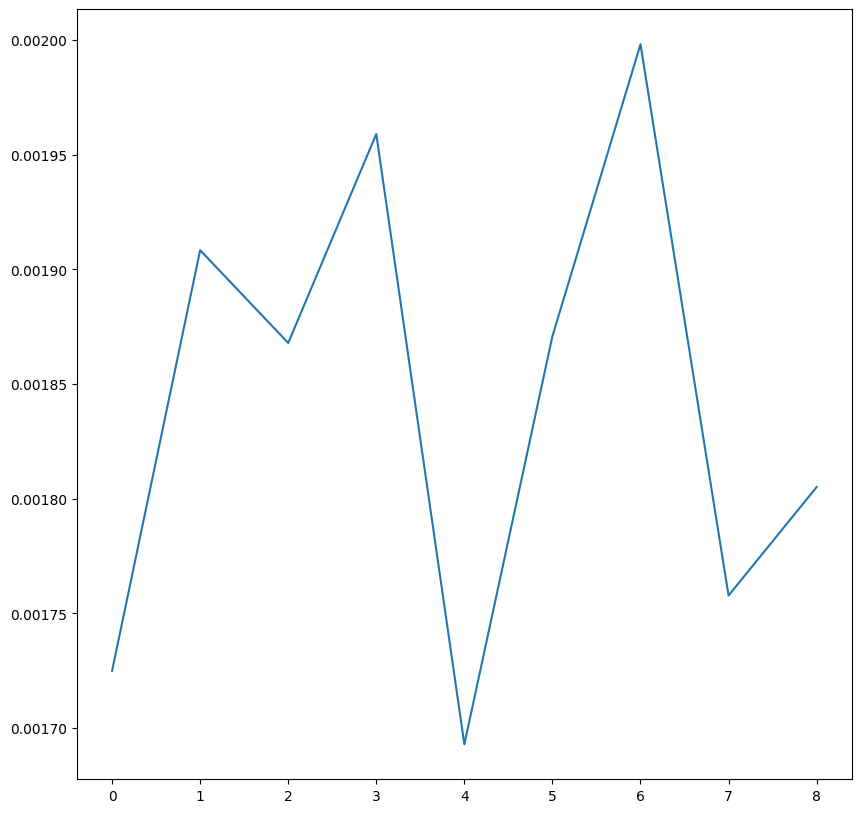

In [ ]:
distances_centers = distance_matrix(encoded_test, centroids)
print(distances_centers.shape)
avg_ditance2center = np.mean(distances_centers, axis=0)
print(avg_ditance2center)
plt.plot(avg_ditance2center)
plt.show()

In [ ]:
predicted_class = np.argmin(distances_centers, axis=1)
print(max(predicted_class))
print(max(labels_test))
print(predicted_class.shape)

8
8
(9465,)


confusion matrix
[[  22   16   52    6  727    5    3  154   60]
 [ 319  734    0    0   19    0    0    3    0]
 [ 289  304    5   96    3    0    0  395    0]
 [   1   64   18  653    0    0    0  282    0]
 [   0    0  547    0  290    1   45  150   48]
 [   0    0    0    0    0    1 1000    0    0]
 [   0    0   61    0    0    0  964    0    0]
 [ 181   31  122   87  592    0    0   35   11]
 [   9   11    0  439   29    0   29   11  541]]
classification_report
              precision    recall  f1-score   support

           0       0.03      0.02      0.02      1045
           1       0.63      0.68      0.66      1075
           2       0.01      0.00      0.01      1092
           3       0.51      0.64      0.57      1018
           4       0.17      0.27      0.21      1081
           5       0.14      0.00      0.00      1001
           6       0.47      0.94      0.63      1025
           7       0.03      0.03      0.03      1059
           8       0.82      0.51      0.

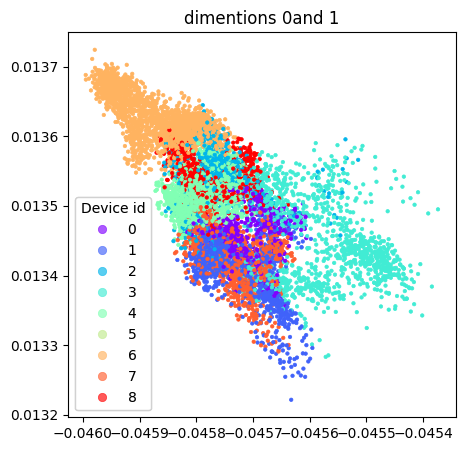

In [ ]:
print('confusion matrix')
conf_mx =confusion_matrix(labels_test, predicted_class)
print(conf_mx)

print('classification_report')
print(classification_report(labels_test, predicted_class))

scatter_plot(np.array(encoded_test), np.array(predicted_class))
plt.show()

In [ ]:
def plotting_2d_data(encoded_data, dev_labels, dimentions=[0, 1]):
    X = np.array(encoded_data)
    plt.rcParams["figure.figsize"] = (10,10)
    plt.scatter(X[:, dimentions[0]], X[:, dimentions[1]], c=dev_labels, marker=".", linewidths=0.5, s=20)
    plt.show()

# Check miss classification in 2D
T_SNE_test = TSNE(n_components=2, learning_rate='auto', init='pca', perplexity=10).fit_transform(np.array(encoded_test))

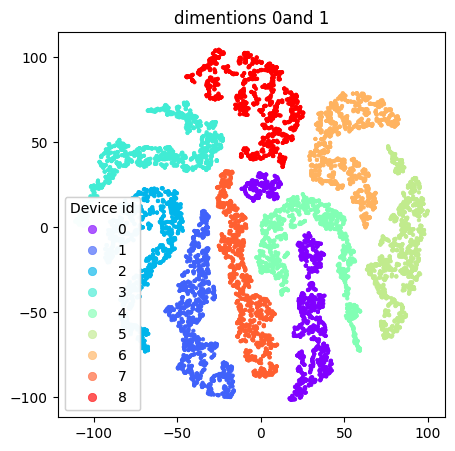

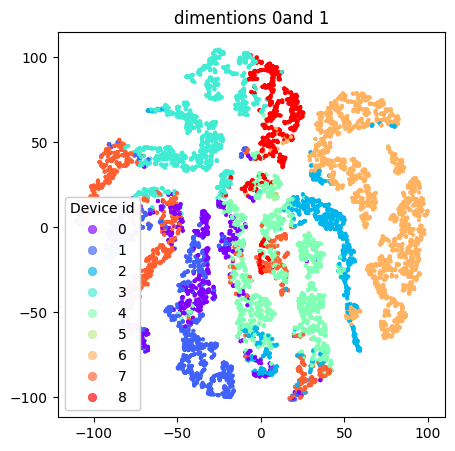

In [ ]:
scatter_plot(T_SNE_test, labels_test)
scatter_plot(T_SNE_test, predicted_class)
plt.show()
